# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('toxic_comments.csv')

In [3]:
data.info()
print(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
   Unnamed: 0                                               text  toxic
0           0  Explanation\nWhy the edits made under my usern...      0
1           1  D'aww! He matches this background colour I'm s...      0
2           2  Hey man, I'm really not trying to edit war. It...      0
3           3  "\nMore\nI can't make any real suggestions on ...      0
4           4  You, sir, are my hero. Any chance you remember...      0
5           5  "\n\nCongratulations from me as well, use the ...      0
6           6       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1
7           7  Your vandalism to the Matt Shirvington artic

Столбец Unnamed: 0 дублирует индексы, удаляю его

In [4]:
data = data.drop('Unnamed: 0', axis=1)

In [5]:
data.duplicated().sum()

0

В данных явных ошибок не обнаружено, дубликатов не выявлено.

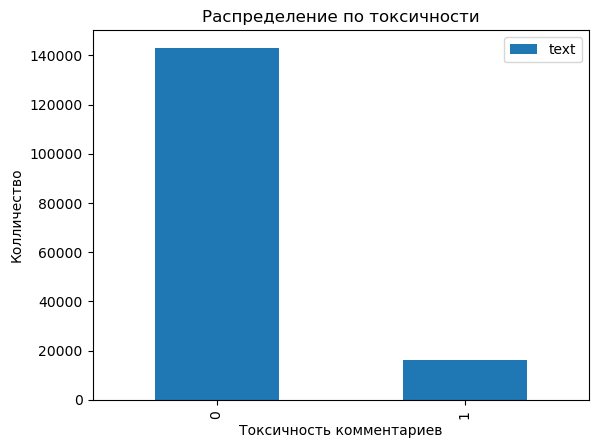

In [6]:
data.pivot_table(index='toxic', values='text', aggfunc='count').plot(
    title='Распределение по токсичности', kind='bar')
plt.xlabel('Токсичность комментариев')
plt.ylabel('Колличество')
plt.show()

Дальше нужно лемматизировать текст

In [7]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
from tqdm.notebook import tqdm
tqdm.pandas()

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_clear(text): 
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    text = " ".join(text)
    text = text.lower()
    text = re.sub(r'[^a-zA-z ]', ' ', text)
    text = text.split()
    return " ".join(text)

data['lemm'] = data['text'].progress_apply(lambda x: lemmatize_clear(x))

[nltk_data] Downloading package punkt to /Users/lena/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lena/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lena/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


  0%|          | 0/159292 [00:00<?, ?it/s]

In [8]:
train, valid = train_test_split(data, random_state=12345, test_size=0.2)
valid, test = train_test_split(valid, random_state=12345, test_size=0.5)

In [9]:
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))
count = TfidfVectorizer(stop_words=stopwords)

count_train = count.fit_transform(list(train['lemm']))
count_valid = count.transform(list(valid['lemm']))
count_test = count.transform(list(test['lemm']))

target_train = train['toxic']
target_valid = valid['toxic']
target_test = test['toxic']

[nltk_data] Downloading package stopwords to /Users/lena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Обучение

In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

c_par_best = 0
f1_logistic_best = 0

for c_par in range(5,15):
    model_regress = LogisticRegression(random_state=12345, C=c_par)
    model_regress.fit(count_train, target_train)
    predictions = model_regress.predict(count_valid)
    f1_logistic = f1_score(target_valid, predictions)
    if f1_logistic > f1_logistic_best:
        f1_logistic_best = f1_logistic
        c_par_best = c_par
    
print('f1_logistic_best', f1_logistic_best, 'c_par_best', c_par_best)

f1_logistic_best 0.7803528190937392 c_par_best 13


In [11]:
f1_tree_best = 0
depth_best = 0

for depth in range(1,31):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(count_train, target_train)
    predictions = model_tree.predict(count_valid)
    f1_tree = f1_score(target_valid, predictions)
    if f1_tree > f1_tree_best:
        f1_tree_best = f1_tree
        depth_best = depth
        
print('f1_tree_best', f1_tree_best, 'depth_best', depth_best)

f1_tree_best 0.6917910447761195 depth_best 29


In [12]:
f1_cat_best = 0
iterations_best = 0

for iterat in range(1,16):
    model_cat = CatBoostClassifier(loss_function="Logloss", iterations=iterat) 
    model_cat.fit(count_train, target_train,verbose=50)
    predictions = model_cat.predict(count_valid)
    f1_cat = f1_score(target_valid, predictions)
    if f1_cat > f1_cat_best:
        f1_cat_best = f1_cat
        iterations_best = iterat
        
print('f1_cat_best', f1_cat_best, 'iterations_best', iterations_best)

Learning rate set to 0.5
0:	learn: 0.3396811	total: 2.94s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3396811	total: 2.2s	remaining: 2.2s
1:	learn: 0.2591015	total: 3.46s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3396811	total: 1.69s	remaining: 3.38s
2:	learn: 0.2352129	total: 4.14s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3396811	total: 1.41s	remaining: 4.24s
3:	learn: 0.2208021	total: 5.16s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3396811	total: 1.42s	remaining: 5.7s
4:	learn: 0.2119321	total: 6.38s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3396811	total: 1.4s	remaining: 7.02s
5:	learn: 0.2056070	total: 7.57s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3396811	total: 1.44s	remaining: 8.62s
6:	learn: 0.2011333	total: 8.9s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3396811	total: 1.42s	remaining: 9.95s
7:	learn: 0.1962841	total: 10.9s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3396811	total: 1.42s	remaining: 11

In [13]:
model_regress = LogisticRegression(random_state=12345, C=c_par_best)
model_regress.fit(count_train, target_train)
predictions = model_regress.predict(count_valid)
f1_logistic = f1_score(target_valid, predictions)
    
print('f1_logistic', f1_logistic, 'c_par_best', c_par_best)

f1_logistic 0.7803528190937392 c_par_best 13


Лучшей моделью оказалась LogisticRegression с гиперпараметром С=13, проверяем на тестовой выборке.

In [14]:
predict_regress_test = model_regress.predict(count_test)
f1_regress_test = f1_score(target_test, predict_regress_test)
print('f1_regress_test', f1_regress_test)

f1_regress_test 0.7764866712235133


## Выводы

Лучшей моделью оказалась LogisticRegression с гиперпараметром С=13. f1 на тестовой выборке 0.776 (больше целевого 0.75).